# Taxi-v3 Environment Exploration

This notebook explores the Taxi-v3 environment from Gymnasium to understand its characteristics before training agents.

## Environment Description

The Taxi problem involves a taxi navigating a 5×5 grid world to:
1. Pick up a passenger at one of 4 designated locations (R, G, Y, B)
2. Drop them off at their destination

**Observation Space:** Discrete(500)
- 5×5 grid = 25 taxi positions
- 5 passenger locations (4 locations + in taxi)
- 4 destination locations
- Total: 25 × 5 × 4 = 500 states

**Action Space:** Discrete(6)
- 0: Move south
- 1: Move north
- 2: Move east
- 3: Move west
- 4: Pick up passenger
- 5: Drop off passenger

**Rewards:**
- -1 per step
- +20 for successful delivery
- -10 for illegal pick-up or drop-off

In [ ]:
from pathlib import Path

import gymnasium as gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from reinforcement_learning_taxi.environments import TaxiActionMaskWrapper, TaxiFeatureWrapper

sns.set_style("whitegrid")
sns.set_palette("husl")

## Create Environment

In [2]:
env = gym.make("Taxi-v3", render_mode="ansi")

print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Number of states: {env.observation_space.n}")
print(f"Number of actions: {env.action_space.n}")

Observation space: Discrete(500)
Action space: Discrete(6)
Number of states: 500
Number of actions: 6


## Visualize Initial State

In [3]:
state, info = env.reset(seed=42)
print(f"Initial state: {state}")
print("\nInitial environment:")
print(env.render())

Initial state: 386

Initial environment:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




## State Decoding

The state is encoded as an integer - we decode it to understand its components.

In [4]:
def decode_state(state):
    """Decode state into taxi position, passenger location, and destination."""
    taxi_row = state // 100
    taxi_col = (state // 20) % 5
    passenger_loc = (state // 4) % 5
    destination = state % 4
    return taxi_row, taxi_col, passenger_loc, destination

taxi_row, taxi_col, pass_loc, dest = decode_state(state)
print(f"Taxi position: ({taxi_row}, {taxi_col})")
print(f"Passenger location: {pass_loc}")
print(f"Destination: {dest}")

action_names = ["South", "North", "East", "West", "Pickup", "Dropoff"]
print(f"\nAvailable actions: {action_names}")

Taxi position: (3, 4)
Passenger location: 1
Destination: 2

Available actions: ['South', 'North', 'East', 'West', 'Pickup', 'Dropoff']


## Random Episode

Run an episode with random actions to see how the environment behaves.

In [5]:
state, _ = env.reset(seed=123)
episode_reward = 0
steps = 0
max_steps = 200

print("Running random episode...")
while steps < max_steps:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    steps += 1

    if terminated or truncated:
        break

print(f"\nEpisode finished after {steps} steps")
print(f"Total reward: {episode_reward}")
print(f"Success: {episode_reward > 0}")

Running random episode...

Episode finished after 200 steps
Total reward: -812
Success: False


## Analyze Random Episodes

Collect statistics from multiple random episodes.

In [6]:
n_episodes = 1000
rewards = []
lengths = []
successes = 0

for _ in range(n_episodes):
    state, _ = env.reset()
    episode_reward = 0
    steps = 0

    while steps < 200:
        action = env.action_space.sample()
        state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        steps += 1

        if terminated or truncated:
            break

    rewards.append(episode_reward)
    lengths.append(steps)
    if episode_reward > 0:
        successes += 1

print(f"Random Agent Statistics ({n_episodes} episodes):")
print(f"  Average reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
print(f"  Average episode length: {np.mean(lengths):.2f} ± {np.std(lengths):.2f}")
print(f"  Success rate: {successes / n_episodes * 100:.2f}%")
print(f"  Min/Max reward: {np.min(rewards):.2f} / {np.max(rewards):.2f}")

Random Agent Statistics (1000 episodes):
  Average reward: -773.29 ± 95.82
  Average episode length: 197.13 ± 16.97
  Success rate: 0.00%
  Min/Max reward: -983.00 / -86.00


## Visualize Reward Distribution

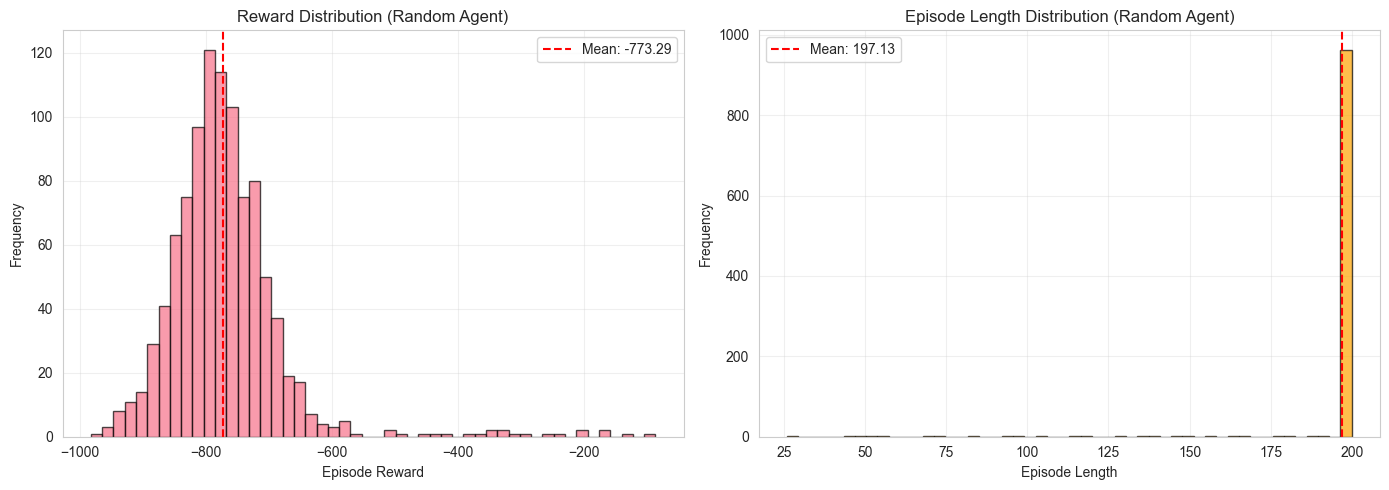

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(rewards, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(rewards), color='r', linestyle='--', label=f'Mean: {np.mean(rewards):.2f}')
axes[0].set_xlabel('Episode Reward')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Reward Distribution (Random Agent)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(np.mean(lengths), color='r', linestyle='--', label=f'Mean: {np.mean(lengths):.2f}')
axes[1].set_xlabel('Episode Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Episode Length Distribution (Random Agent)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
env.close()

In [9]:
# Save 10 random episodes into one video
render_dir = Path('../results/renders')
render_dir.mkdir(parents=True, exist_ok=True)

env_render = gym.make('Taxi-v3', render_mode='rgb_array')
env_render = TaxiFeatureWrapper(env_render)
env_render = TaxiActionMaskWrapper(env_render)

video_path = render_dir / 'random_env_10runs.mp4'
fps = 10
pause_frames = fps

seeds = [999 + i for i in range(10)]
episode_lengths = []

with imageio.get_writer(video_path, fps=fps) as writer:
    for i, seed in enumerate(seeds, start=1):
        state, _ = env_render.reset(seed=seed)
        frame = env_render.render()
        writer.append_data(frame)
        done = False
        steps = 0
        while not done and steps < 200:
            action = env_render.action_space.sample()
            state, _reward, terminated, truncated, _ = env_render.step(action)
            frame = env_render.render()
            writer.append_data(frame)
            done = terminated or truncated
            steps += 1
        episode_lengths.append(steps)
        print(f'Episode {i}: steps={steps}')
        if i != len(seeds):
            for _ in range(pause_frames):
                writer.append_data(frame)

env_render.close()
print(f'Video saved to {video_path}')
print(f'Summary: mean_steps={sum(episode_lengths) / len(episode_lengths):.2f}')

/Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1: steps=200
Episode 2: steps=200
Episode 3: steps=200
Episode 4: steps=200
Episode 5: steps=200
Episode 6: steps=200
Episode 7: steps=200
Episode 8: steps=200
Episode 9: steps=200
Episode 10: steps=200
Video saved to ../results/renders/random_env_10runs.mp4
Summary: mean_steps=200.00
